In [ ]:
import os
from google.colab import drive
drive.mount('/content/gdrive')

path = "gdrive/MyDrive/추천시스템/teamproject/data/"
os.listdir(path)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


['links.csv',
 'tags.csv',
 'movies.csv',
 'ratings.csv',
 'movies_crawling_sample.csv',
 '1207 sample_data_FI.csv',
 '1207 sample_data_pp.csv',
 'ratings_refined.csv']

In [ ]:
!pip install pyspark
!apt-get install openjdk-8-jdk-headless -qq

## 라이브러리

In [ ]:
import pyspark
import numpy as np
import pandas as pd
import os

from pyspark.context import SparkContext
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit, col
from pyspark.sql import functions as F
from pyspark.ml.classification import RandomForestClassifier


In [ ]:
sc = pyspark.SparkContext()
spark = SparkSession.builder.getOrCreate()

ValueError: ignored

## 데이터

In [ ]:
movies = pd.read_csv(path + "1207 sample_data_FI.csv")

In [ ]:
ratings = pd.read_csv(path + "ratings_refined.csv", usecols=['userId', 'movieId', 'rating'])

In [ ]:
df = pd.merge(ratings, movies, on='movieId', how='left')

In [ ]:
df.head()

,userId,movieId,rating,age_rating,era,runtime,continent
0,1,1,4.0,All,['B'],[-1.2915281995335486],NaN
1,1,3,4.0,15,['B'],[-0.3024393157693134],NaN
2,1,6,4.0,18,['B'],[3.1099173332172994],NaN
3,1,47,5.0,18,['B'],[0.9833762331241928],NaN
4,1,50,5.0,18,['B'],[-0.05516709482825472],NaN


In [ ]:
movies

,movieId,age_rating,era,runtime,continent
0,1,All,['B'],[-1.2915281995335486],NaN
1,2,All,['B'],[-0.1540759832046779],NaN
2,3,15,['B'],[-0.3024393157693134],NaN
3,4,18,['B'],[0.835012900559558],NaN
4,5,All,['B'],[-0.05516709482825472],NaN
...,...,...,...,...,...
1787,3329,PG-13,['N'],[-0.2035304273928895],OC
1788,3330,12,['G'],[0.835012900559558],NaN
1789,3331,18,['N'],[-0.5002570925221604],NaN
1790,3334,15,['G'],[-0.35189375995752564],NaN


### 데이터 null 값 제거

In [ ]:
df['continent'].value_counts()

EU    4538
OC     468
AS     349
AF      37
SA      29
Name: continent, dtype: int64

In [ ]:
df['continent'].isna().sum()

95368

In [ ]:
df_cleaned = df.dropna()
df_cleaned

,userId,movieId,rating,age_rating,era,runtime,continent
8,1,151,5.0,15,['B'],[1.5768295633827332],EU
30,1,552,4.0,12,['B'],[-0.10462153901646631],EU
91,1,1348,4.0,12,['S'],[-0.6486204250867958],EU
98,1,1517,5.0,18,['B'],[-0.6486204250867958],EU
110,1,1793,4.0,"Rated R for strong sexuality and language, and...",['B'],[-0.05516709482825472],EU
...,...,...,...,...,...,...,...
99660,610,3089,3.0,12,['G'],[-0.8958926460278546],EU
99664,610,3174,4.0,15,['B'],[0.5382862354302871],EU
99666,610,3265,5.0,15,['B'],[1.0328306773124043],AS
99668,610,3285,3.5,18,['C'],[0.5877406796184986],EU


In [ ]:
df_cleaned.isna().sum()

userId        0
movieId       0
rating        0
age_rating    0
era           0
runtime       0
continent     0
dtype: int64

### 데이터 continent label encoding 수행

AF -> 0 <br>
AS -> 1 <br>
EU -> 2 <br>
OC -> 3 <br>
SA -> 4 <br>


In [ ]:
from sklearn.preprocessing import LabelEncoder
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'continent' column
df_cleaned['continent_encoded'] = label_encoder.fit_transform(df_cleaned['continent'])

<ipython-input-145-ace27497e7c9>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['continent_encoded'] = label_encoder.fit_transform(df_cleaned['continent'])


In [ ]:
df_cleaned['continent_encoded'].value_counts()

2    4538
3     468
1     349
0      37
4      29
Name: continent_encoded, dtype: int64

In [ ]:
df_cleaned = df_cleaned.drop(columns = 'continent', axis = 1)

### age_rating 값 처리

In [ ]:
df_cleaned['age_rating'].value_counts()

15                                                                          1991
18                                                                          1364
12                                                                           780
All                                                                          658
PG                                                                           111
                                                                            ... 
Rated R for some strong sexuality, and for language                            1
Rated R for violence, pervasive language, some sexuality and drug use          1
Rated R for some strong sexuality and language                                 1
Rated R for language and a scene of sexuality                                  1
Rated R for pervasive language and some violence, sexuality and drug use       1
Name: age_rating, Length: 79, dtype: int64

In [ ]:
# unique_ratings = df_cleaned['age_rating'].unique()

# # Print the unique values
# for rating in unique_ratings:
#     print(rating)


In [ ]:
df_cleaned = df_cleaned.drop(columns = 'age_rating', axis = 1)

In [ ]:
df_cleaned

,userId,movieId,rating,era,runtime,continent_encoded
8,1,151,5.0,['B'],[1.5768295633827332],2
30,1,552,4.0,['B'],[-0.10462153901646631],2
91,1,1348,4.0,['S'],[-0.6486204250867958],2
98,1,1517,5.0,['B'],[-0.6486204250867958],2
110,1,1793,4.0,['B'],[-0.05516709482825472],2
...,...,...,...,...,...,...
99660,610,3089,3.0,['G'],[-0.8958926460278546],2
99664,610,3174,4.0,['B'],[0.5382862354302871],2
99666,610,3265,5.0,['B'],[1.0328306773124043],1
99668,610,3285,3.5,['C'],[0.5877406796184986],2


### rating 값 반올림 시행

In [ ]:
df_cleaned['rating'].value_counts()

4.0    1609
3.0    1176
5.0     842
3.5     557
4.5     397
2.0     393
2.5     188
1.0     178
1.5      42
0.5      39
Name: rating, dtype: int64

In [ ]:
import math

df_cleaned['rating'] = df_cleaned['rating'].apply(lambda x: math.ceil(x))

In [ ]:
# df_cleaned['rating'] = df_cleaned['rating'].round(-1)

In [ ]:
df_cleaned['rating'].value_counts()

4    2166
3    1364
5    1239
2     435
1     217
Name: rating, dtype: int64

### era 데이터 값 처리 -> Label encoding

B -> 0 <br>
N -> 3 <br>
G -> 2 <br>
S -> 4 <br>
C -> 1 <br>

In [ ]:
df_cleaned['era_encoded'] = label_encoder.fit_transform(df_cleaned['era'])

In [ ]:
df_cleaned['era'].value_counts()

['B']    3914
['N']     924
['G']     504
['S']      41
['C']      38
Name: era, dtype: int64

In [ ]:
df_cleaned['era_encoded'].value_counts()

0    3914
3     924
2     504
4      41
1      38
Name: era_encoded, dtype: int64

In [ ]:
df_cleaned = df_cleaned.drop(columns = 'era', axis = 1)

### runtime 데이터 처리

In [ ]:
df_cleaned['runtime'] = df_cleaned['runtime'].str.replace(r'[\[\]]', '')
df_cleaned['runtime'] = df_cleaned['runtime'].astype(float)
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5421 entries, 8 to 99671
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   userId             5421 non-null   int64  
 1   movieId            5421 non-null   int64  
 2   rating             5421 non-null   int64  
 3   runtime            5421 non-null   float64
 4   continent_encoded  5421 non-null   int64  
 5   era_encoded        5421 non-null   int64  
dtypes: float64(1), int64(5)
memory usage: 296.5 KB


<ipython-input-161-bf90a1571b9e>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df_cleaned['runtime'] = df_cleaned['runtime'].str.replace(r'[\[\]]', '')


### 데이터 확인

In [ ]:
df_cleaned.columns[df_cleaned.isna().any()].tolist() #isna NULL 값을 찾기, any()를 사용해서 모든 컬럼

[]

In [ ]:
df_cleaned = df_cleaned.reset_index(drop=True)
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5421 entries, 0 to 5420
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   userId             5421 non-null   int64  
 1   movieId            5421 non-null   int64  
 2   rating             5421 non-null   int64  
 3   runtime            5421 non-null   float64
 4   continent_encoded  5421 non-null   int64  
 5   era_encoded        5421 non-null   int64  
dtypes: float64(1), int64(5)
memory usage: 254.2 KB


## Spark

### Spark dataframe으로 변경

In [ ]:
from pyspark.sql import Row

# Pandas 데이터프레임의 컬럼 이름 추출
columns = df_cleaned.columns

# Pandas 데이터프레임의 데이터를 리스트로 추출
data_rows = df_cleaned.values.tolist()

# Spark 데이터프레임 생성
spark_df = spark.createDataFrame([Row(**{col: val for col, val in zip(columns, row)}) for row in data_rows])

In [ ]:
spark_df.show(5)

+------+-------+------+--------------------+-----------------+-----------+
|userId|movieId|rating|             runtime|continent_encoded|era_encoded|
+------+-------+------+--------------------+-----------------+-----------+
|   1.0|  151.0|   5.0|  1.5768295633827332|              2.0|        0.0|
|   1.0|  552.0|   4.0|-0.10462153901646631|              2.0|        0.0|
|   1.0| 1348.0|   4.0| -0.6486204250867958|              2.0|        4.0|
|   1.0| 1517.0|   5.0| -0.6486204250867958|              2.0|        0.0|
|   1.0| 1793.0|   4.0|-0.05516709482825472|              2.0|        0.0|
+------+-------+------+--------------------+-----------------+-----------+
only showing top 5 rows



### 예측을 위한 데이터 정리

In [ ]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer

In [ ]:
input_columns = ['userId', 'movieId', 'rating', 'runtime', 'continent_encoded', 'era_encoded']

assembler = VectorAssembler(inputCols=input_columns, outputCol = 'features')
output = assembler.transform(spark_df)
output.show(5)

+------+-------+------+--------------------+-----------------+-----------+--------------------+
|userId|movieId|rating|             runtime|continent_encoded|era_encoded|            features|
+------+-------+------+--------------------+-----------------+-----------+--------------------+
|   1.0|  151.0|   5.0|  1.5768295633827332|              2.0|        0.0|[1.0,151.0,5.0,1....|
|   1.0|  552.0|   4.0|-0.10462153901646631|              2.0|        0.0|[1.0,552.0,4.0,-0...|
|   1.0| 1348.0|   4.0| -0.6486204250867958|              2.0|        4.0|[1.0,1348.0,4.0,-...|
|   1.0| 1517.0|   5.0| -0.6486204250867958|              2.0|        0.0|[1.0,1517.0,5.0,-...|
|   1.0| 1793.0|   4.0|-0.05516709482825472|              2.0|        0.0|[1.0,1793.0,4.0,-...|
+------+-------+------+--------------------+-----------------+-----------+--------------------+
only showing top 5 rows



In [ ]:
data = output.select('features', 'rating')
data.show(5)

+--------------------+------+
|            features|rating|
+--------------------+------+
|[1.0,151.0,5.0,1....|   5.0|
|[1.0,552.0,4.0,-0...|   4.0|
|[1.0,1348.0,4.0,-...|   4.0|
|[1.0,1517.0,5.0,-...|   5.0|
|[1.0,1793.0,4.0,-...|   4.0|
+--------------------+------+
only showing top 5 rows



In [ ]:
# I_indexer = StringIndexer(inputCol='rating', outputCol = 'labelIndex')
# finalized_data = I_indexer.fit(data).transform(data)

In [ ]:
# finalized_data.show(200)

## RandomForest

In [ ]:
train_data, test_data = data.randomSplit([0.7, 0.3])

In [ ]:
rf = RandomForestClassifier(numTrees=100, featuresCol="features", labelCol="rating")
model = rf.fit(train_data)

In [ ]:
importances = model.featureImportances
print("Feature Importances:", importances)


Feature Importances: (6,[0,1,2,3,4,5],[0.005534652268249565,0.004311569487274666,0.9834813415058836,0.0044232372778134224,0.00154290355355178,0.0007062959072268939])


In [ ]:
importances

SparseVector(6, {0: 0.0055, 1: 0.0043, 2: 0.9835, 3: 0.0044, 4: 0.0015, 5: 0.0007})

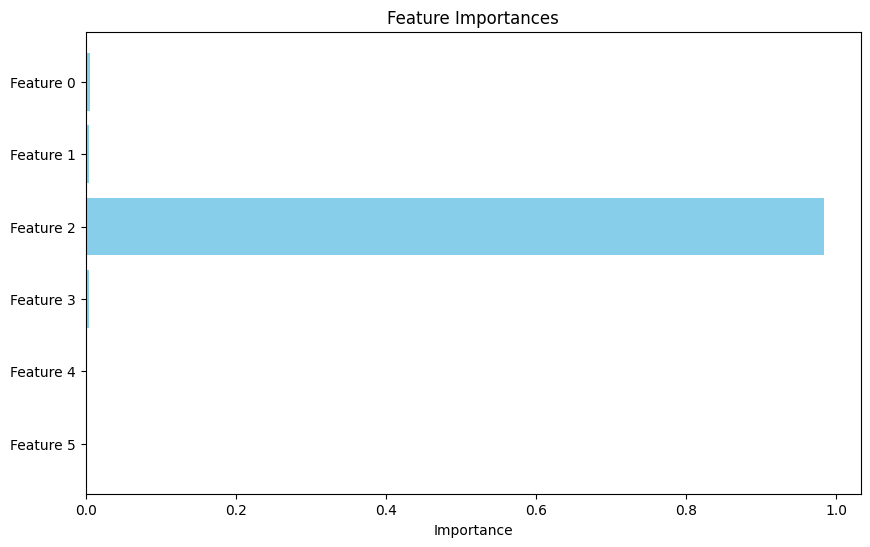

In [ ]:
import matplotlib.pyplot as plt

# Define the feature names and importances
feature_names = ["Feature 0", "Feature 1", "Feature 2", "Feature 3", "Feature 4", "Feature 5"]
# Create a bar chart
plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances, color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()

In [ ]:
importances_list = importances.tolist()

# Get the indices of the features sorted by importance (descending order)
sorted_indices = sorted(range(len(importances_list)), key=lambda i: importances_list[i], reverse=True)

feature_columns = ['userId', 'movieId', 'rating', 'runtime', 'continent_encoded', 'era_encoded']

# Get the sorted feature names
sorted_features = [feature_columns[i] for i in sorted_indices]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(sorted_features, importances_list)
plt.xlabel("Feature Importance")
plt.title("RandomForest Feature Importances")
plt.gca().invert_yaxis()  # Invert y-axis for better visualization
plt.show()


AttributeError: ignored

In [1]:
# Set a threshold for feature importance
# importance_threshold = 0.05  # Adjust this value as needed

# # Get the names of important feature columns
# important_features = [feature_names[i] for i, score in enumerate(importances) if score >= importance_threshold]


In [2]:
# # Select only the important features from the original DataFrame
# selected_features_df = df[important_features + ["label"]]

# # Assemble the selected features into a vector column
# assembler = VectorAssembler(inputCols=important_features, outputCol="features")
# selected_features_df = assembler.transform(selected_features_df)

In [ ]:
train_data.take(1)

In [ ]:
spark.stop()